# 6.6: Canada Wildfires Sourcing & Analyzing Time Series Data
** **

## This script contains the following:


1. Importing libraries and files


2. Data cleaning (Subsetting, wrangling, and cleaning time-series data)


3. Time series analysis: decomposition


4. Testing for stationarity via ADF (Augmented Dickey Fuller) test


5. Stationarizing the Canadian WildFires data
    - 5.1 Normal Differencing method
    - 5.2 Seasonal Differencing method
    - 5.3 Transformation method (Square root) and differencing method on top 
   
6. Time series forecasting with ARIMA model (Bonus)

      - 6.1 Splitting the data 
      - 6.2 Running and fitting the model
      - 6.3 Iterating


** **

### 1. Importing libraries and files
** **


In [1]:
import quandl
import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

In [6]:
# Creating shared path

path = r'C:\Users\mehrn\OneDrive\Desktop\CareerFoundry Materials\Tasks\06 Advanced Analytics\15-03-2023 Canada Wildfires Analysis'

In [7]:
# Importing the fires data

df_fires = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'updated_wildfires.pkl'))

In [8]:
df_fires.head()

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name,size_class,total_fires
fire_id,,,,,,,,,,
0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera,Class C,149391
1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera,Class C,149391
2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera,Class E,149391
3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera,Class E,149391
4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera,Class B,149391


### 2. Data cleaning (Subsetting, wrangling, and cleaning time-series data)
** **


In [9]:
df_fires.dtypes

src_agency      object
latitude       float64
longitude      float64
rep_date        object
size           float64
cause           object
prot_zone       object
eco_name        object
size_class      object
total_fires      int64
dtype: object

In [10]:
# Convert the rep_date to datetime64 data type
from datetime import datetime

# Create a datetime column from 'rep_date' with format of year-month-day
df_fires['rep_date'] = pd.to_datetime(df_fires['rep_date'], format='%Y-%m-%d')

In [11]:
df_fires.dtypes

src_agency             object
latitude              float64
longitude             float64
rep_date       datetime64[ns]
size                  float64
cause                  object
prot_zone              object
eco_name               object
size_class             object
total_fires             int64
dtype: object

In [12]:
# Filter data between two dates (last 20 years)

df_filtered = df_fires.loc[(df_fires['rep_date'] >= '2001-01-01') & (df_fires['rep_date'] < '2022-01-01')]

# Display
df_filtered

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name,size_class,total_fires
fire_id,,,,,,,,,,
105315,BC,55.80000,-124.816700,2005-06-20,0.0100,L,,Montane Cordillera,Class A,149391
109890,BC,59.83920,-127.450000,2001-05-06,0.0300,H,,Boreal Cordillera,Class A,149391
109891,BC,59.80420,-127.478000,2001-05-06,0.2000,H,,Boreal Cordillera,Class B,149391
109892,BC,59.92270,-128.514300,2001-05-06,0.0100,H,,Boreal Cordillera,Class A,149391
109899,BC,59.24480,-131.916800,2003-07-01,0.0090,L,,Boreal Cordillera,Class A,149391
...,...,...,...,...,...,...,...,...,...,...
423826,PC-WB,59.61015,-113.985117,2021-07-08,65.1000,L,Monitored Response,Taiga Plain,Class D,1910
423827,PC-WL,49.11120,-113.836000,2021-03-04,7.6000,H-PB,Prescribed Fire,Montane Cordillera,Class C,61
423828,PC-WL,49.11220,-113.840500,2021-03-17,2.9000,H-PB,Prescribed Fire,Montane Cordillera,Class B,61


In [13]:
# Grouping by date and cause to count the human-caused(H) fires in the past 20 years

df_sub = df_filtered.groupby('rep_date')['cause'].apply(lambda x: (x=='H').sum()).reset_index(name='human_caused_count')
df_sub

,rep_date,human_caused_count
0,2001-01-01,4
1,2001-01-02,1
2,2001-01-08,1
3,2001-01-11,1
4,2001-01-14,1
...,...,...
5567,2021-12-09,1
5568,2021-12-10,1
5569,2021-12-11,1
5570,2021-12-13,0


In [14]:
# Checking for missing values

df_sub.isnull().sum()

rep_date              0
human_caused_count    0
dtype: int64

In [15]:
# Checking for duplicates

dup = df_sub[df_sub.duplicated()]
dup

,rep_date,human_caused_count


In [16]:
# Set the datetime (rep_date) variable as the index of the dataframe.

df_sub = df_sub.set_index('rep_date')
df_sub

,human_caused_count
rep_date,
2001-01-01,4
2001-01-02,1
2001-01-08,1
2001-01-11,1
2001-01-14,1
...,...
2021-12-09,1
2021-12-10,1
2021-12-11,1


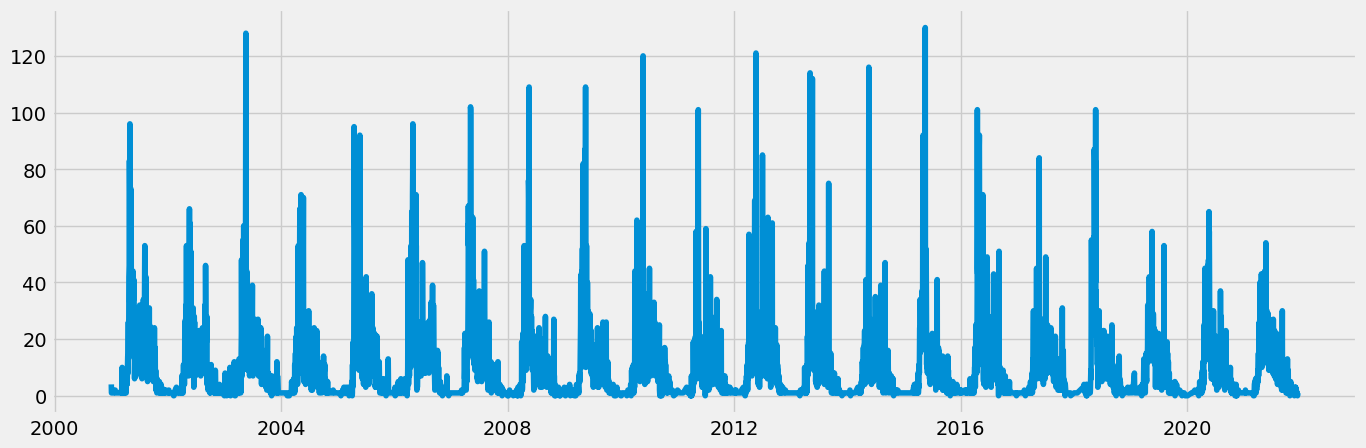

In [17]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

### 3. Time-series analysis: decomposition
** **

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive',  period=365)

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

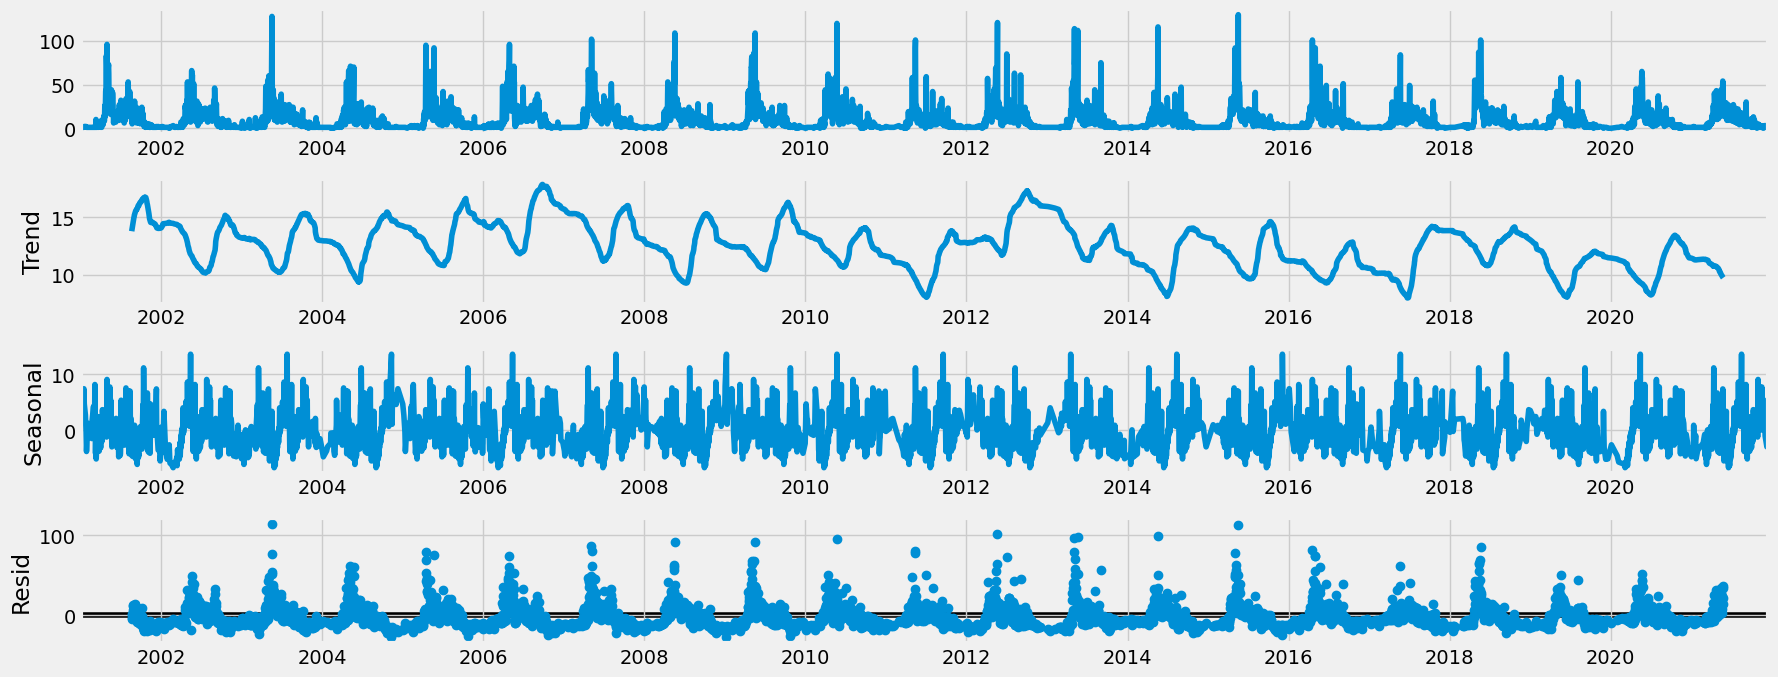

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Observation:
Looking at decomposition plots (which represent the different components of our time series), the Residual component seems to be more prominent. We have a trend and also have seasonality in the time series where its value ranges from ~-5 to ~+13. Also, the Residual chart values is showing an obvious pattern similar to the original data. As we used an additive model, any data point with a value of 0 (in each component) doesn't have a contribution to the fires' time series.

### 4. Testing for stationarity via ADF (Augmented Dickey Fuller) test
** **


- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

- HA: The time series is stationary.

- If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.


In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['human_caused_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -9.939405e+00
p-value                        2.689263e-17
Number of Lags Used            2.900000e+01
Number of Observations Used    5.542000e+03
Critical Value (1%)           -3.431531e+00
Critical Value (5%)           -2.862062e+00
Critical Value (10%)          -2.567048e+00
dtype: float64


### Results:

We cannot reject the null hypothesis since the P-Value is not less than 0.05. So this time series is Non-Stationary. To build or train an ML model we need to make our time series stationary. To do that we can use three different methods: Differencing (normal, seasonal), Rolling stats (moving average), and differencing+Transformation (log, square root, cube root). Here we would use the normal differencing approach first. If data is still Non-Stationary (After the ADF test) we have to repeat this step with another method until the data converts to a stationary time series.

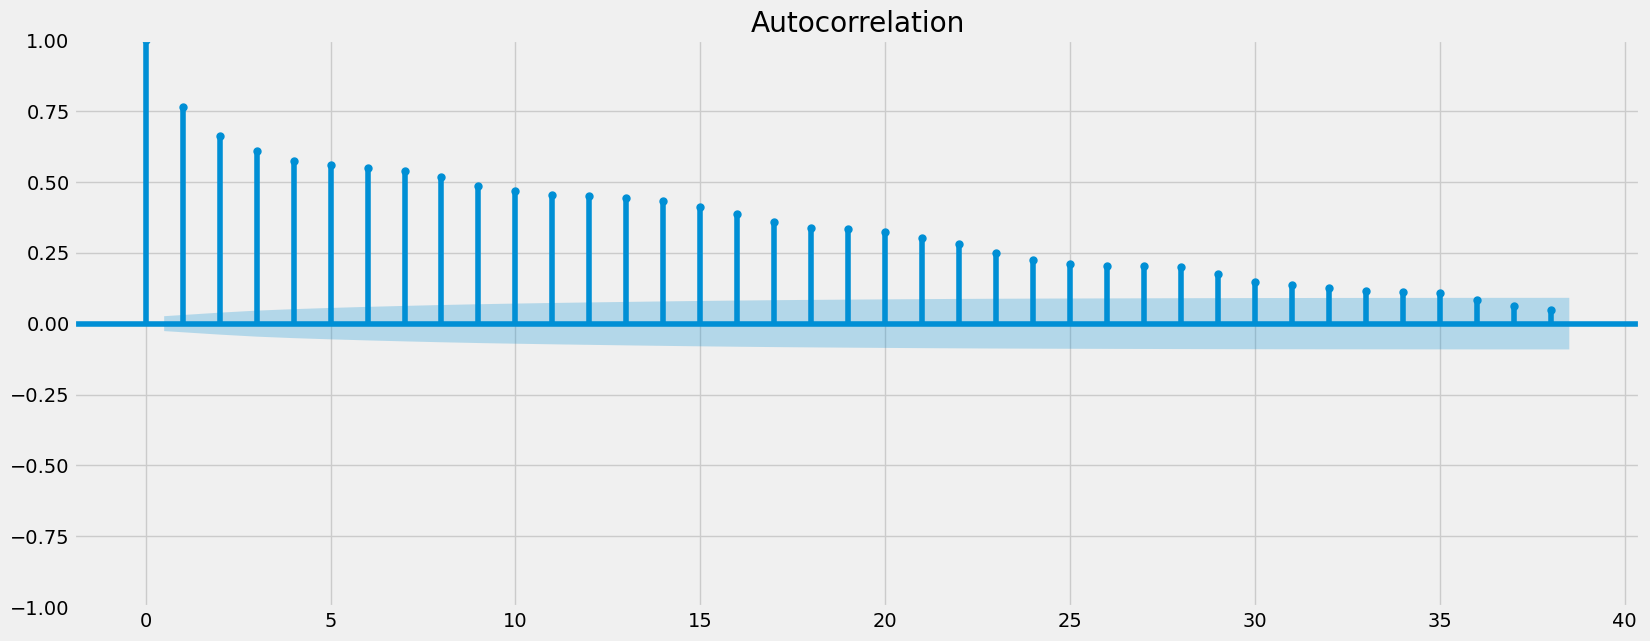

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub)
plt.show()

### 5. Stationarizing the Canadian WildFires data
** **


#### 5.1 Normal Differencing method
** **


In [23]:
data_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,human_caused_count
rep_date,
2001-01-02,-3.0
2001-01-08,0.0
2001-01-11,0.0
2001-01-14,0.0
2001-01-16,0.0


In [26]:
data_diff.columns

Index(['human_caused_count'], dtype='object')

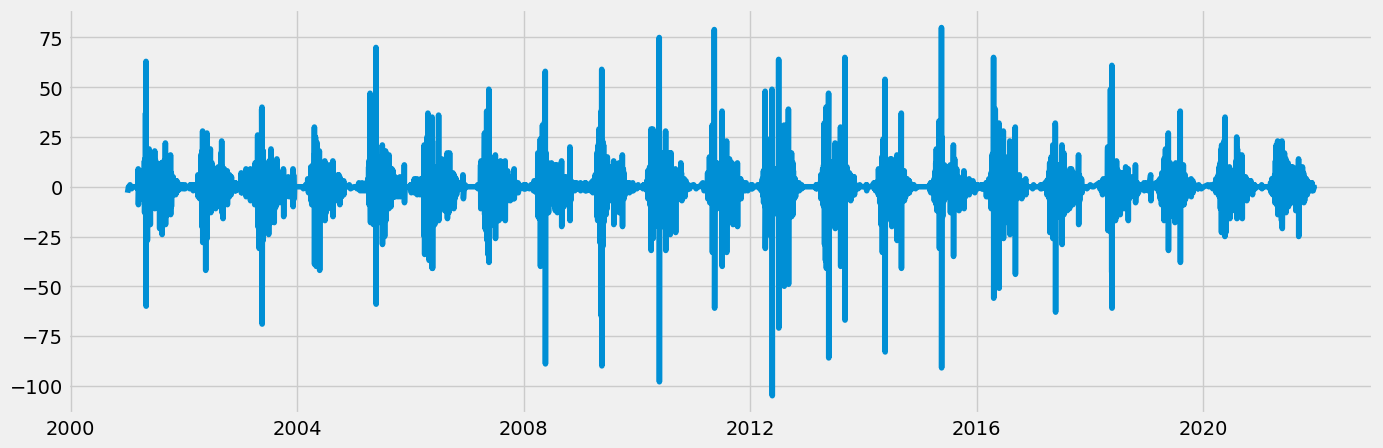

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.750939e+01
p-value                        4.343134e-30
Number of Lags Used            2.600000e+01
Number of Observations Used    5.544000e+03
Critical Value (1%)           -3.431530e+00
Critical Value (5%)           -2.862061e+00
Critical Value (10%)          -2.567048e+00
dtype: float64


#### Results:
We still cannot reject the null hypothesis since the P-Value (4.34) is not less than 0.05. We will conduct another round of differencing with a seasonal one which has a 365 lags for the last years data points.

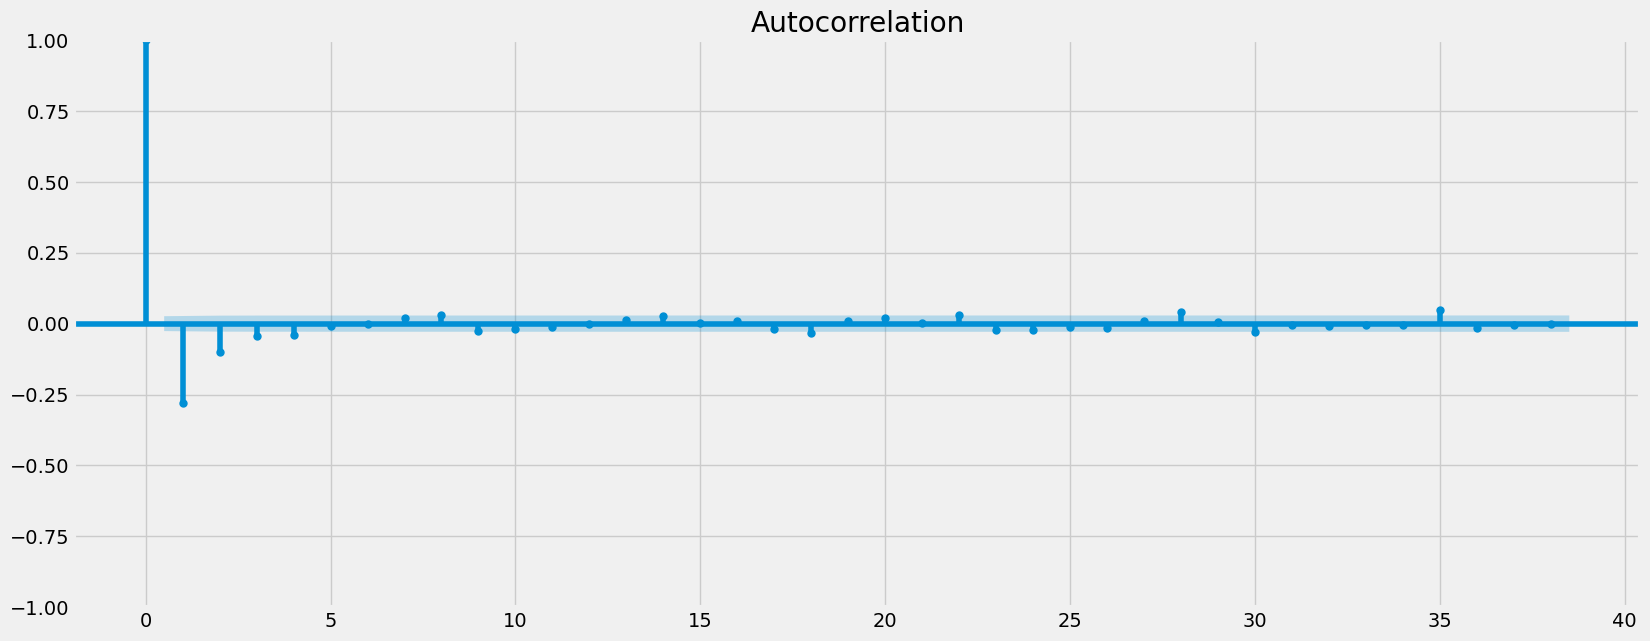

In [29]:
plot_acf(data_diff)
plt.show()

#### 5.2 Seasonal Differencing method
** **


In [30]:
data_diff_s = df_sub - df_sub.shift(365) # The df.shift(365) function turns the observation to t-365, making the whole thing t - (t -365)

In [31]:
data_diff_s.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [32]:
data_diff_s.head()

,human_caused_count
rep_date,
2002-05-18,45.0
2002-05-19,46.0
2002-05-20,65.0
2002-05-21,23.0
2002-05-22,48.0


In [33]:
data_diff_s.columns

Index(['human_caused_count'], dtype='object')

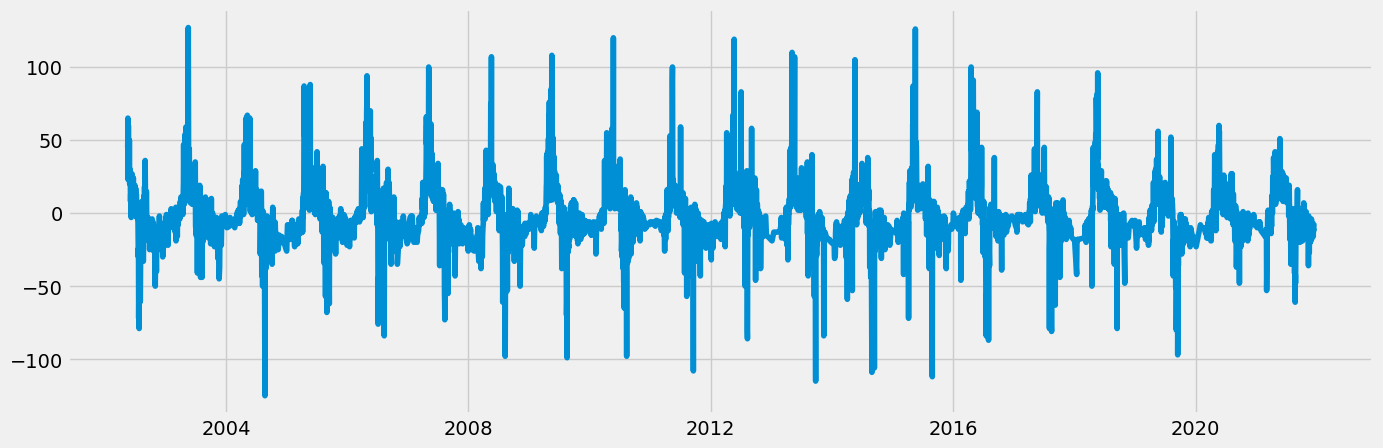

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_s)

In [35]:
dickey_fuller(data_diff_s)

Dickey-Fuller Stationarity test:
Test Statistic                -8.491564e+00
p-value                        1.309208e-13
Number of Lags Used            2.800000e+01
Number of Observations Used    5.178000e+03
Critical Value (1%)           -3.431614e+00
Critical Value (5%)           -2.862098e+00
Critical Value (10%)          -2.567067e+00
dtype: float64


#### Results:
We still cannot reject the null hypothesis since the P-Value (1.30) is not less than 0.05. In next step we will conduct another round of stationarizing time series via Transformation method.

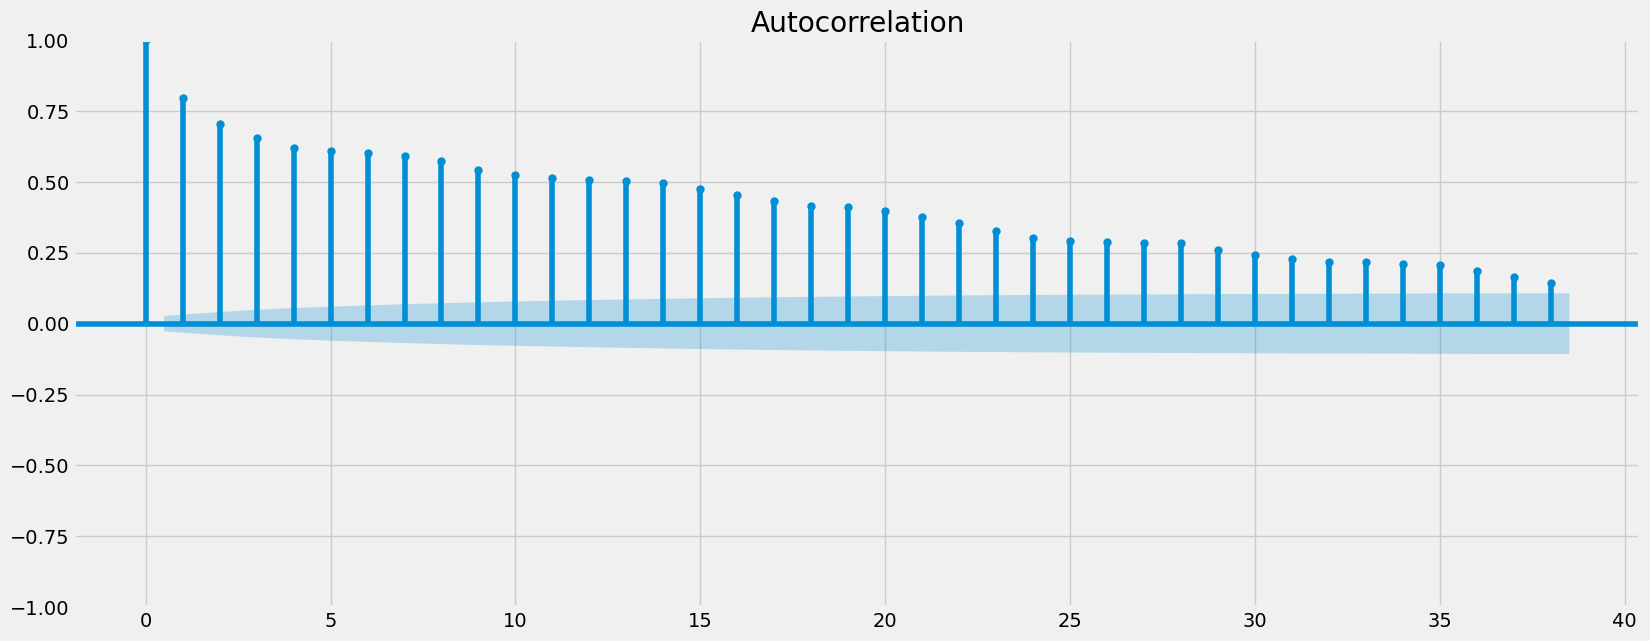

In [36]:
plot_acf(data_diff_s)
plt.show()

#### 5.3 Transformation method (Square root) and differencing method on top 
** **


In [37]:
# Taking square root of #fires ('human_caused_count') for transformation

data_adj_sqr = np.sqrt(df_sub)
data_adj_sqr

,human_caused_count
rep_date,
2001-01-01,2.0
2001-01-02,1.0
2001-01-08,1.0
2001-01-11,1.0
2001-01-14,1.0
...,...
2021-12-09,1.0
2021-12-10,1.0
2021-12-11,1.0


<AxesSubplot:xlabel='rep_date'>

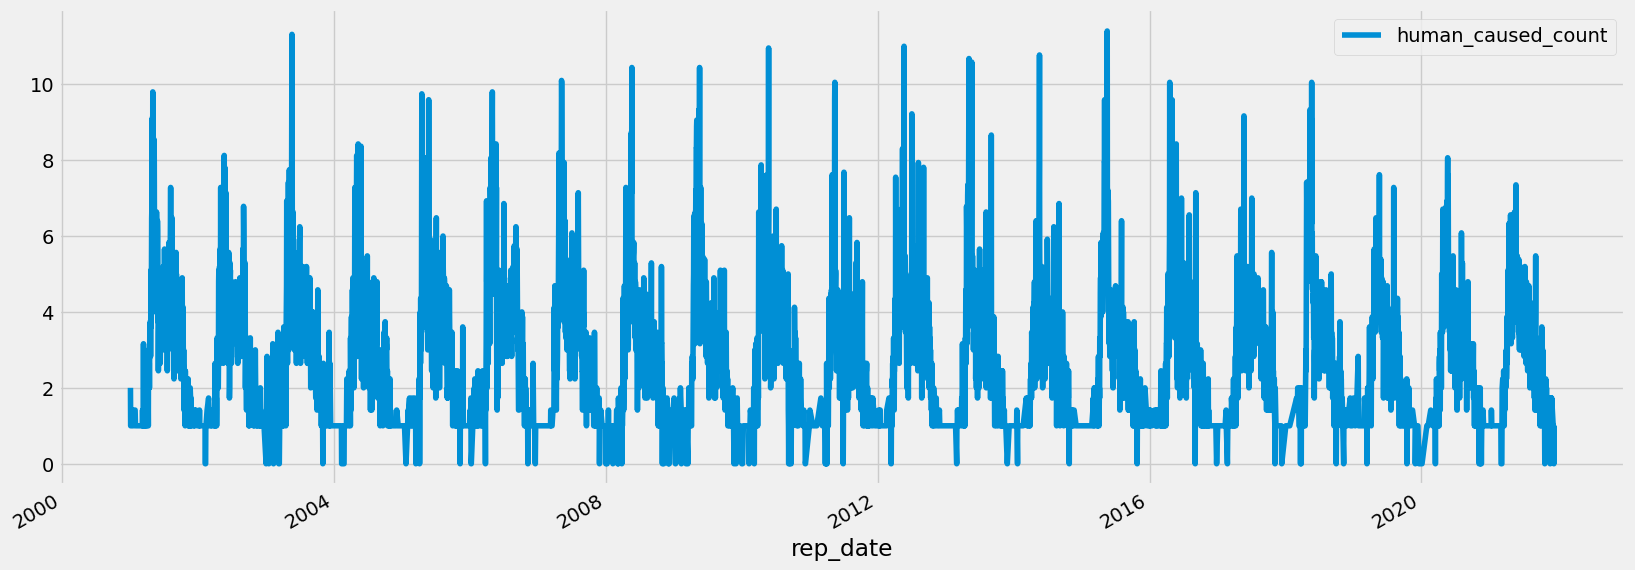

In [38]:
# Running plot for sqrt root values
data_adj_sqr.replace([np,inf, -np.inf],np.nan, inplace = True)
data_adj_sqr.dropna().plot()

In [39]:
# Calculating the difference of square root transformations

data_sqr_diff= data_adj_sqr - data_adj_sqr.shift(365)

In [40]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
# Check out what the 'square root+ differencing' did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
data_sqr_diff = data_sqr_diff.dropna()

<Figure size 1500x500 with 0 Axes>

<AxesSubplot:xlabel='rep_date'>

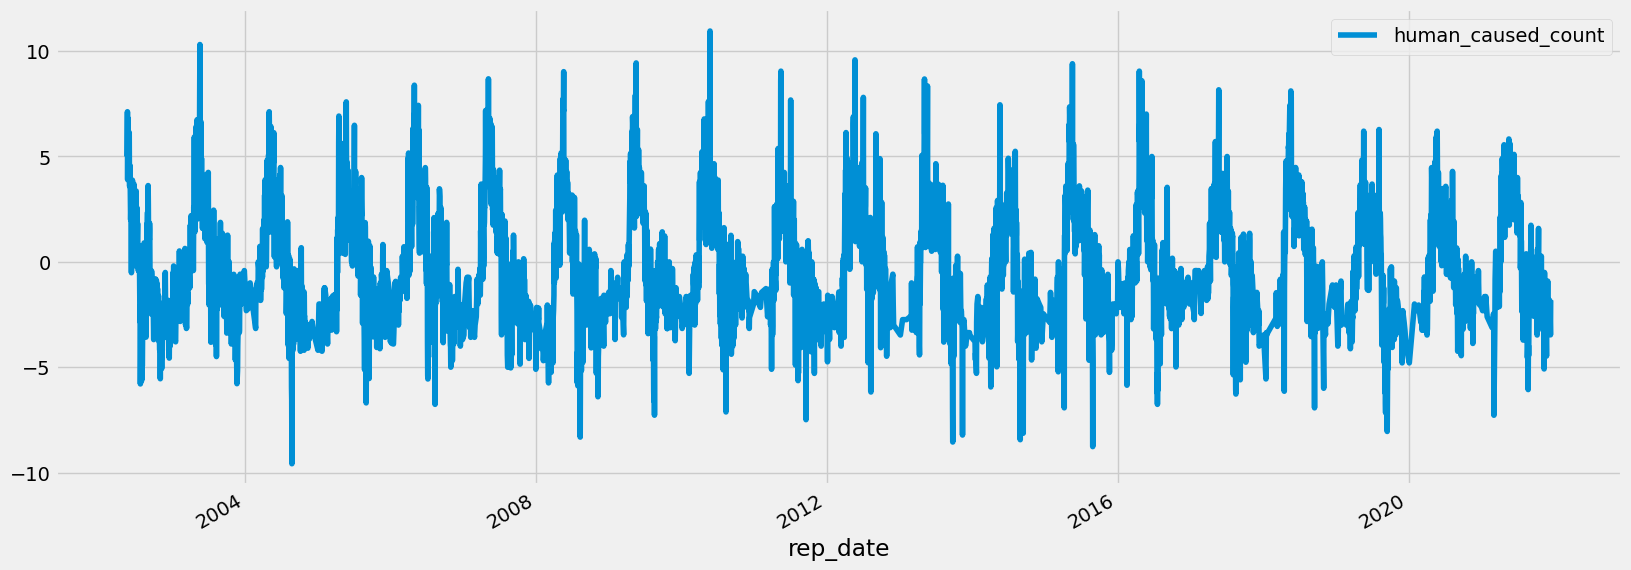

In [41]:
data_sqr_diff.plot()

In [42]:
dickey_fuller(data_sqr_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.052896e+00
p-value                        1.722963e-12
Number of Lags Used            3.000000e+01
Number of Observations Used    5.176000e+03
Critical Value (1%)           -3.431614e+00
Critical Value (5%)           -2.862099e+00
Critical Value (10%)          -2.567067e+00
dtype: float64


#### Results:
We still cannot reject the null hypothesis since the P-Value (1.72) is not less than 0.05. In next step we will conduct another round of stationarizing time series via Rolling Statistics method.

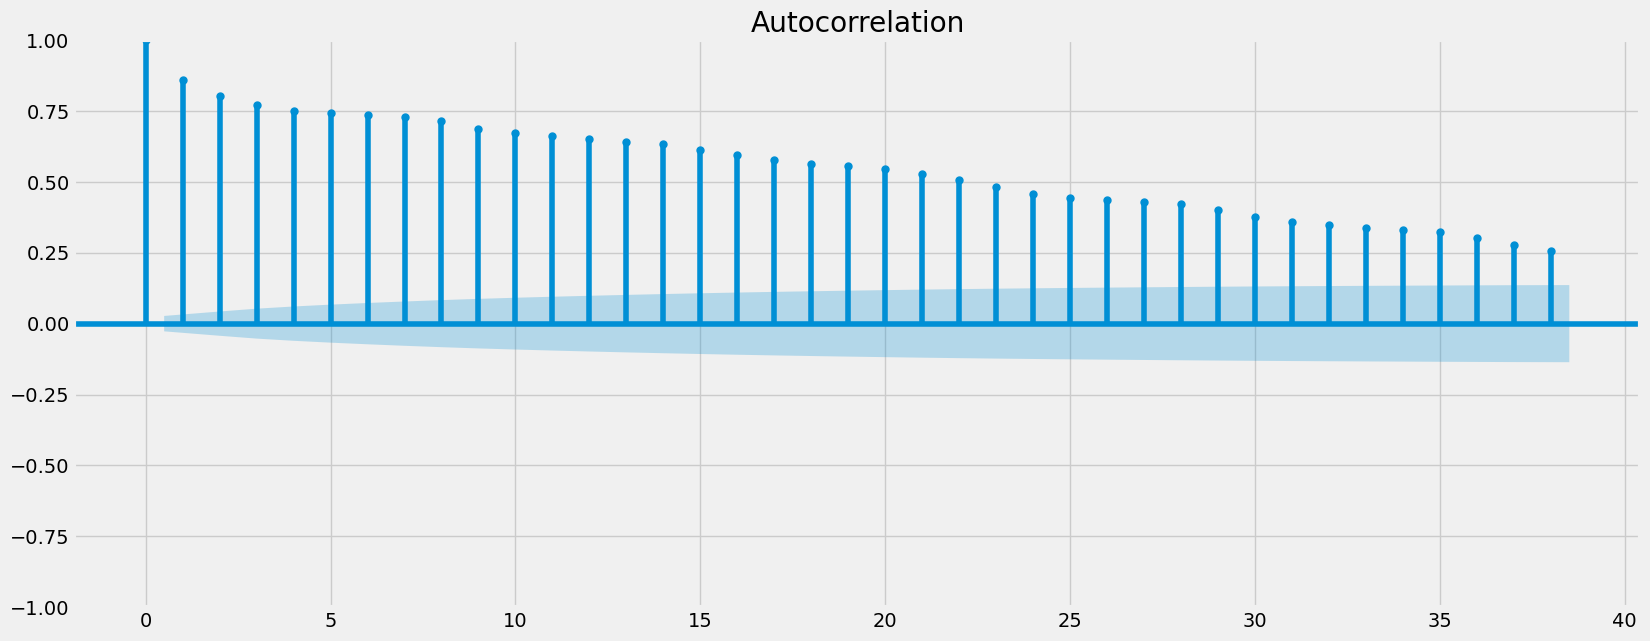

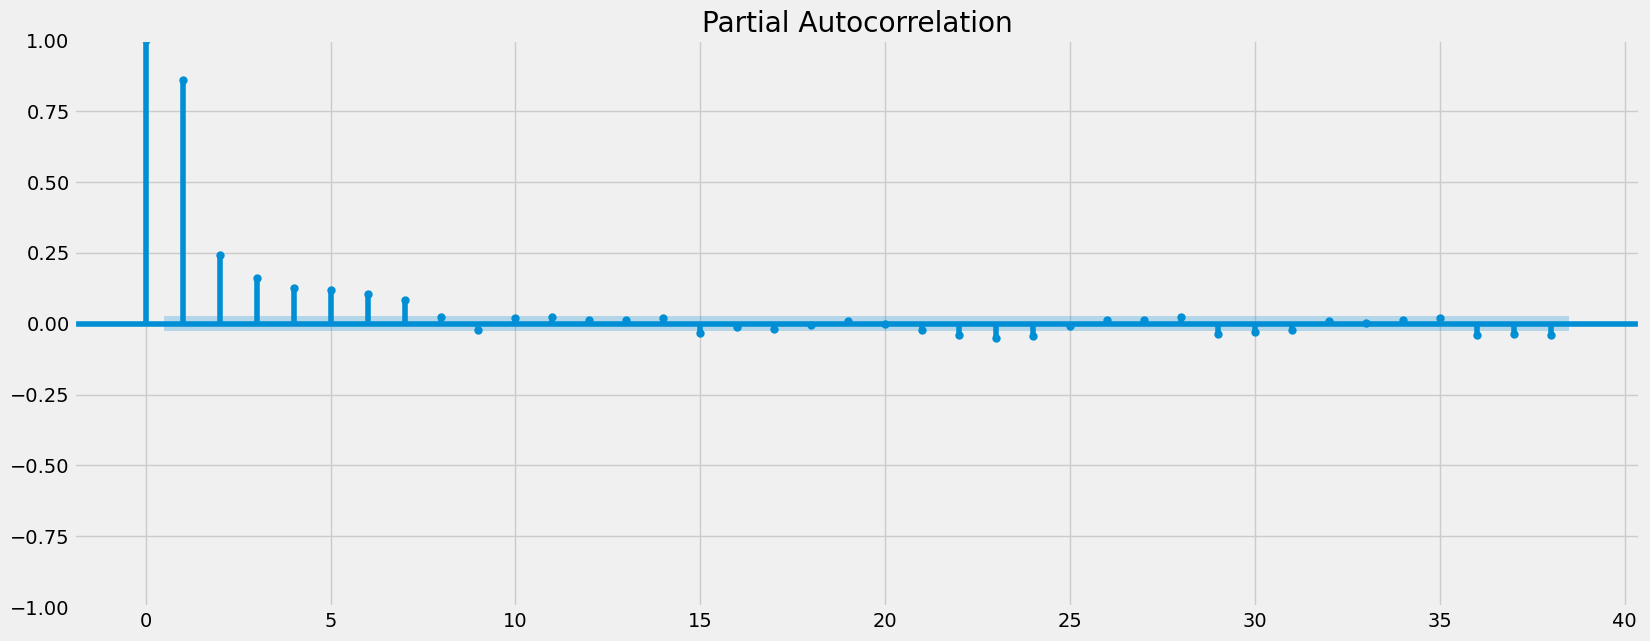

In [43]:
plot_acf(data_sqr_diff)
plot_pacf(data_sqr_diff)
plt.show()


#### 5.4 Rolling Statistics method
** **


In [44]:
# Taking moving average (rolling stat) of data points to make them stationary
data_rs = df_sub.rolling(window = 310).mean()

In [45]:
data_rs = data_rs.dropna()

<AxesSubplot:xlabel='rep_date'>

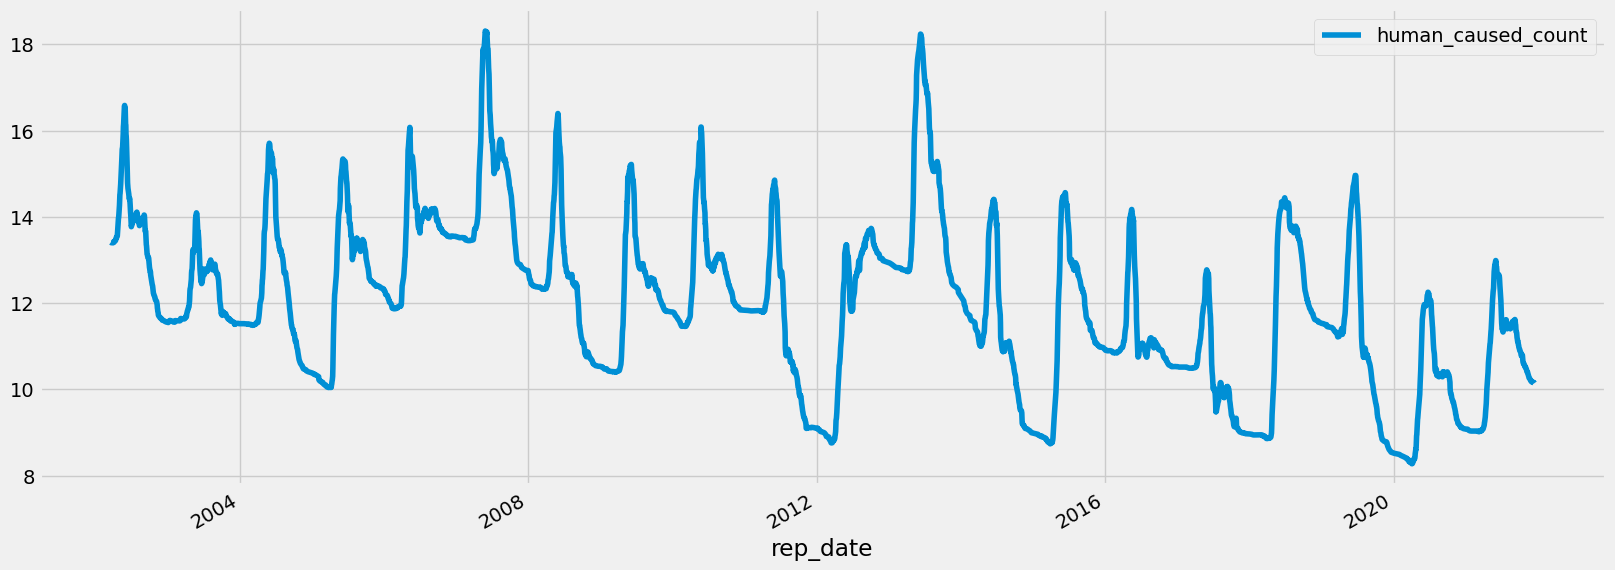

In [46]:
data_rs.plot()

In [47]:
dickey_fuller(data_rs)

Dickey-Fuller Stationarity test:
Test Statistic                   -5.339085
p-value                           0.000005
Number of Lags Used              30.000000
Number of Observations Used    5232.000000
Critical Value (1%)              -3.431600
Critical Value (5%)              -2.862093
Critical Value (10%)             -2.567064
dtype: float64


#### Results:
We can reject the null hypothesis since the P-Value (0.000005) is very small and less than 0.05. Now we can reject the Null hypothesis and say the time series is stationary.

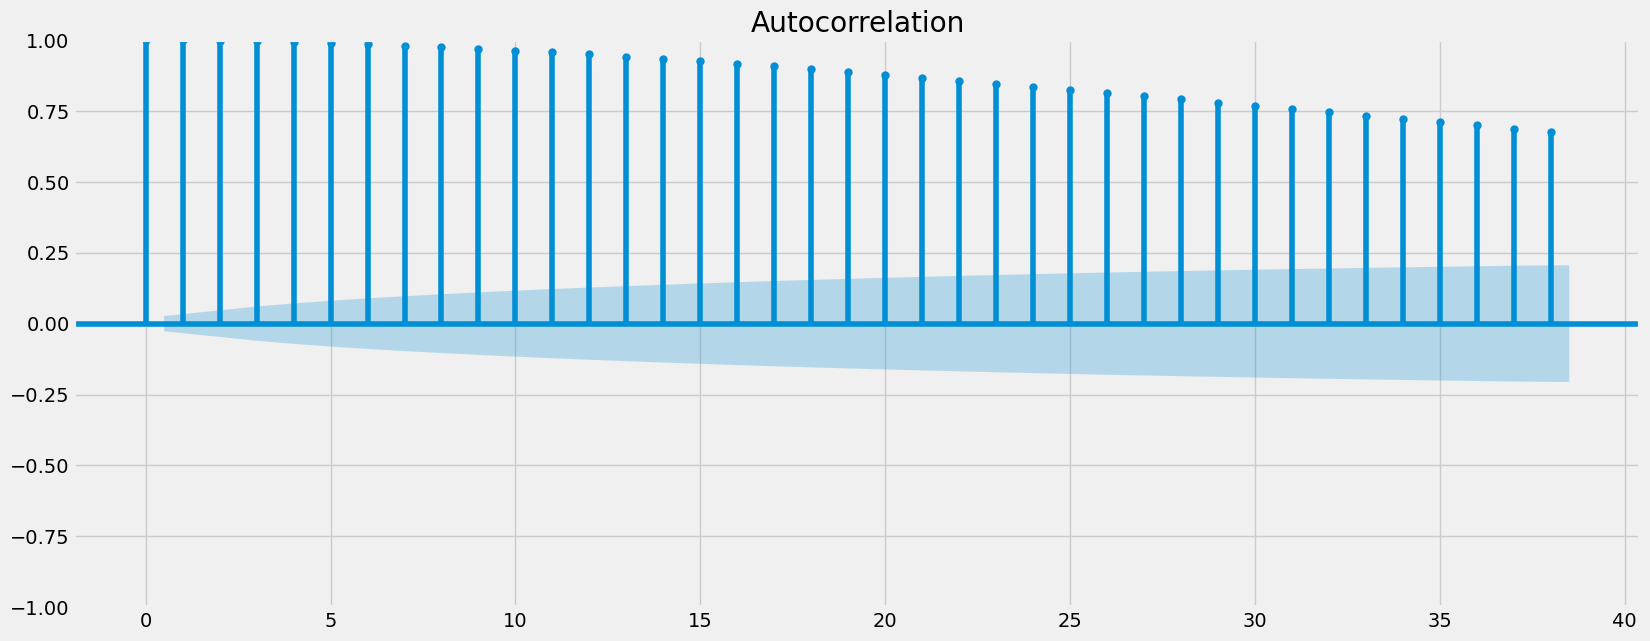

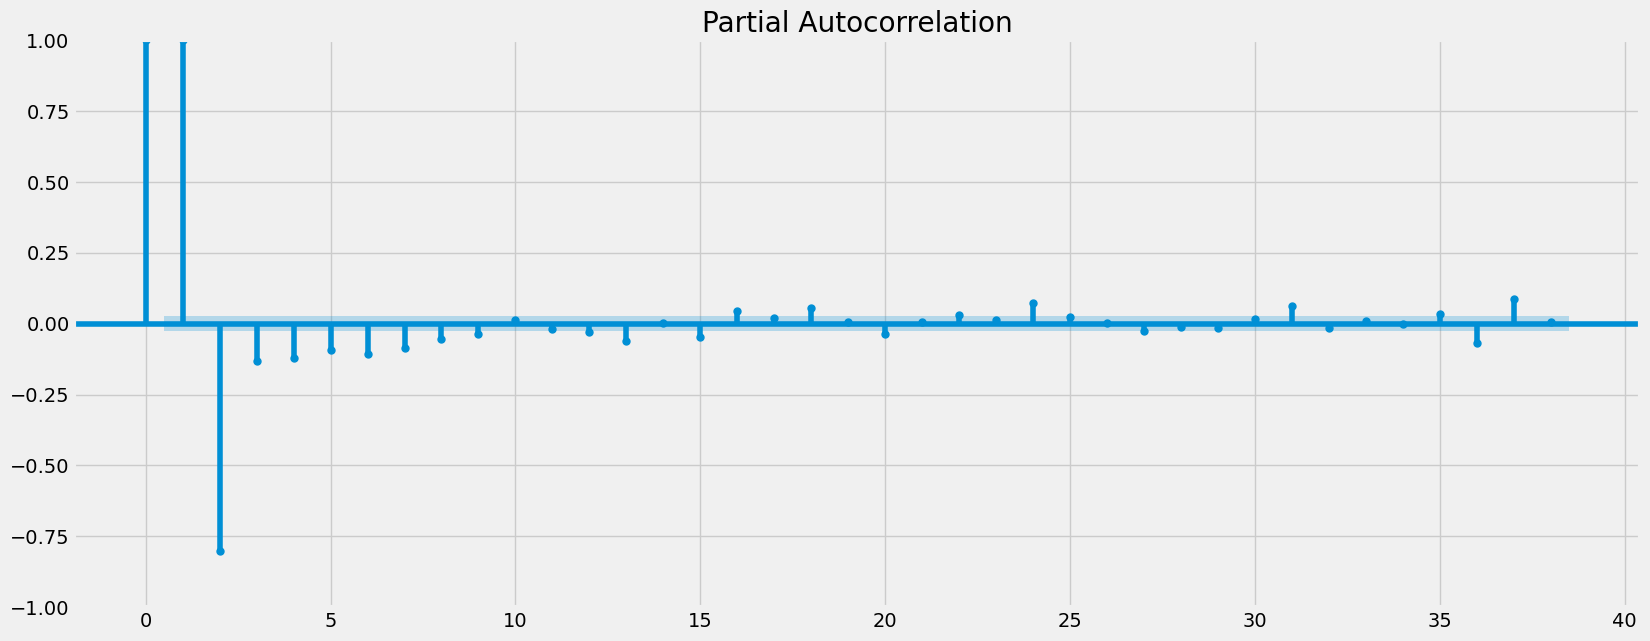

In [48]:
# Plotting ACF (Autocorrelation Function)

plot_acf(data_rs)

# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(data_rs)

plt.show()

#### Results:
In the autocorrelation plot, there are still a number of lines above the blue confidence interval. it’s still not perfect. This means that, despite the Dickey-Fuller test saying that the data is stationary, that stationarity is weak.

In the figure above, looking at Partial Autocorrelation, you can see that we have some highly positive bars. These indicate significant correlations. Let’s start by picking 2 AR terms to compensate for the highest of the partial autocorrelations. This makes **p = 2.**

We also have some significant autocorrelations here (those that run beyond the blue border in the first plot), but for now, we can take a more conservative approach and see what the output is like at **q = 4.** (It’s advisable to start with fewer terms as opposed to more and adjust accordingly further down the line as you begin testing the model.)


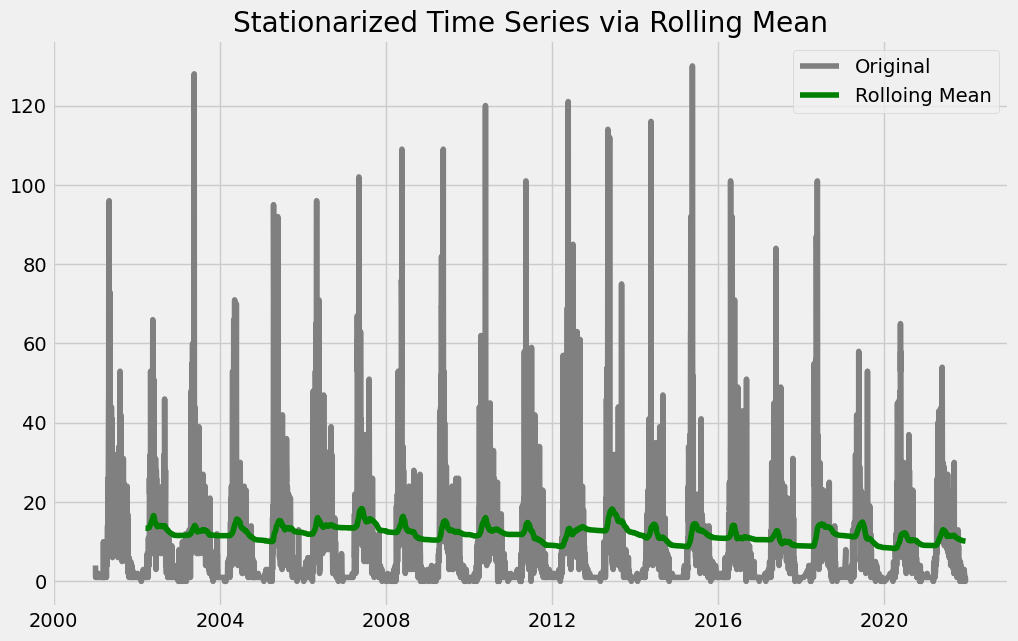

In [49]:
# Presenting how stationarizied plot fits on Original time series

fig = plt.figure(figsize=(11,7))
orig = plt.plot(df_sub, color = 'gray', label= 'Original')
mean = plt.plot(data_rs, color = 'green', label = 'Rolloing Mean')
plt.legend(loc = 'best')
plt.title('Stationarized Time Series via Rolling Mean')
plt.show(block = False)

### 6. Time series forecasting with ARIMA model (Bonus)
** **


#### 6.1 Splitting the data 
** **


In [50]:
data_rs.shape

(5263, 1)

In [51]:
# Split the data

train = data_rs[data_rs.index < '2019-01-01']
test = data_rs[data_rs.index >= '2019-01-01']

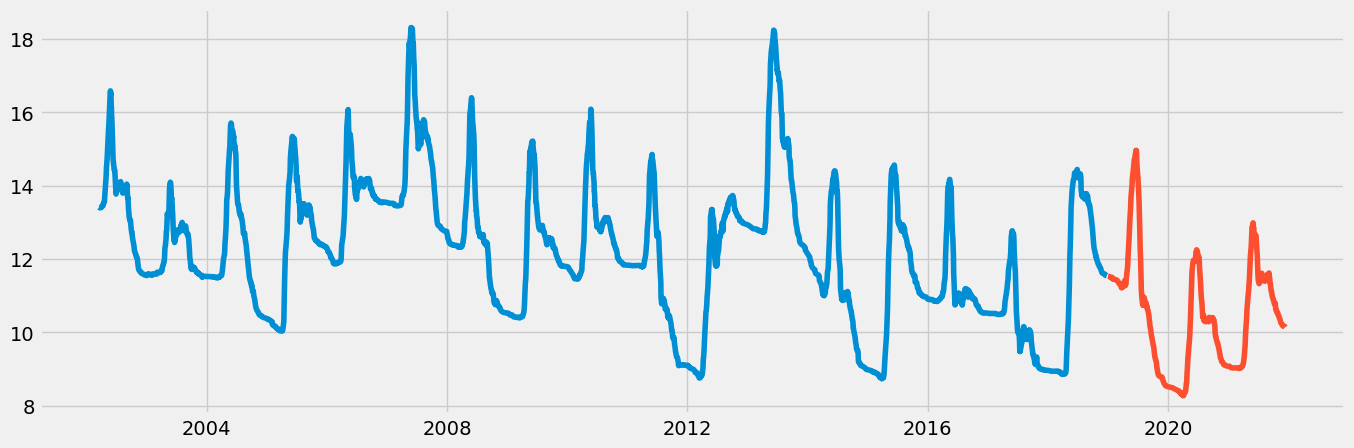

In [52]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [53]:
test.shape

(777, 1)

#### 6.2 Running and fitting the model
** **


In [54]:
from statsmodels.tsa.api import ARIMA# , SARIMAX # Import the model you need

                               SARIMAX Results                                
Dep. Variable:     human_caused_count   No. Observations:                 4486
Model:                 ARIMA(2, 0, 4)   Log Likelihood                7936.027
Date:                Sat, 01 Apr 2023   AIC                         -15856.054
Time:                        10:24:33   BIC                         -15804.784
Sample:                             0   HQIC                        -15837.985
                               - 4486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5771      0.308     40.881      0.000      11.974      13.180
ar.L1          1.9640      0.004    441.788      0.000       1.955       1.973
ar.L2         -0.9648      0.004   -216.764      0.0

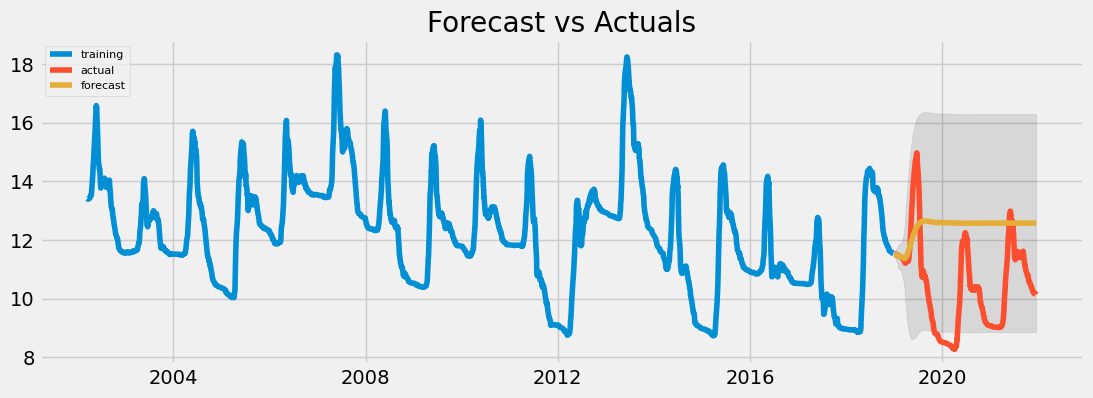

In [68]:
model = ARIMA(train, order=(2, 0, 4))  # ARIMA ORDER = (p,d,q)
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc = fitted.get_forecast(777, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 563 is the shape of the test set

# Make into pandas series
# Make into pandas series
fc_series = fc.predicted_mean # This creates the forecasted curve
lower_series = fc.conf_int().iloc[:, 0] # lower bound of the confidence interval
upper_series = fc.conf_int().iloc[:, 1] # Upper bound of the confidence interval

fc_series.index = test.index
lower_series.index = test.index
upper_series.index = test.index


# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 6.3 Iterating

                               SARIMAX Results                                
Dep. Variable:     human_caused_count   No. Observations:                 4486
Model:                 ARIMA(2, 0, 3)   Log Likelihood                7932.136
Date:                Sat, 01 Apr 2023   AIC                         -15850.271
Time:                        10:27:29   BIC                         -15805.410
Sample:                             0   HQIC                        -15834.461
                               - 4486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5935      0.302     41.719      0.000      12.002      13.185
ar.L1          1.9593      0.005    425.890      0.000       1.950       1.968
ar.L2         -0.9601      0.005   -208.501      0.0

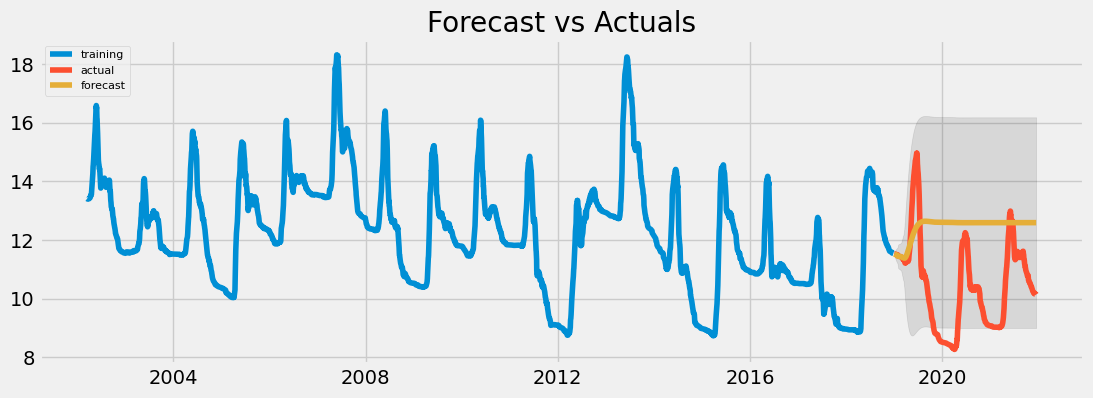

In [78]:
model = ARIMA(train, order=(2, 0, 3))  # ARIMA ORDER = (p,d,q)
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc = fitted.get_forecast(777, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 563 is the shape of the test set

# Make into pandas series
# Make into pandas series
fc_series = fc.predicted_mean # This creates the forecasted curve
lower_series = fc.conf_int().iloc[:, 0] # lower bound of the confidence interval
upper_series = fc.conf_int().iloc[:, 1] # Upper bound of the confidence interval

fc_series.index = test.index
lower_series.index = test.index
upper_series.index = test.index


# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()